In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

from torchsummary import summary

import matplotlib.pyplot as plt
from IPython import display

In [3]:
nGauss = 1000
imgSize = 91

x = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)

widths = np.linspace(2,20,nGauss)

images = torch.zeros(nGauss,1,imgSize,imgSize)


for i in range(nGauss):

  ro = 2*np.random.randn(2)
  G = np.exp(-( (X-ro[0])**2 + (Y-ro[1])**2) / widths[i] )

  G = G + np.random.randn(imgSize,imgSize) / 5

  i1 = np.random.choice(np.arange(2,28))
  i2 = np.random.choice(np.arange(2,6))

  if np.random.randn() > 0:

    G[i1:i1+i2,] = 1
  else:
    G[:,i1:i1+i2] = 1

  images[i,:,:,:] = torch.Tensor(G).view(1, imgSize,imgSize)


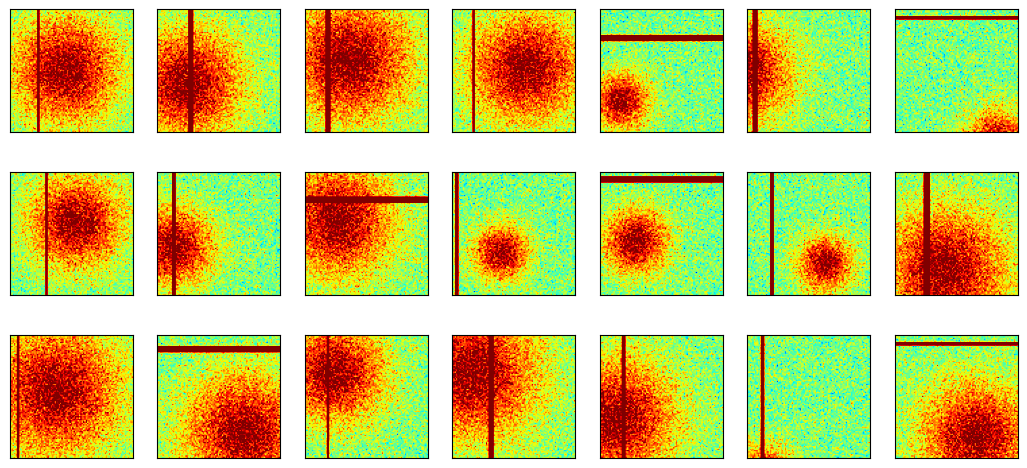

In [4]:
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):
  anypic = np.random.randint(nGauss)
  G = np.squeeze( images[anypic,:,:])
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

In [5]:
def createNet():

  class gausnet(nn.Module):
    def __init__(self):
      super().__init__()

      self.enc = nn.Sequential(
          nn.Conv2d(1,6,3,padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2,2),
          nn.Conv2d(6,4,3,padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2,2),
          )

      self.dec = nn.Sequential(
          nn.ConvTranspose2d(4,6,3,2),
          nn.ReLU(),
          nn.ConvTranspose2d(6,1,3,2),
      )

    def forward(self,x):
        x =  self.enc(x)
        x = self.dec(x)

        return x


  net = gausnet()

  lossfun = nn.BCEWithLogitsLoss()

  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

torch.Size([10, 1, 91, 91])


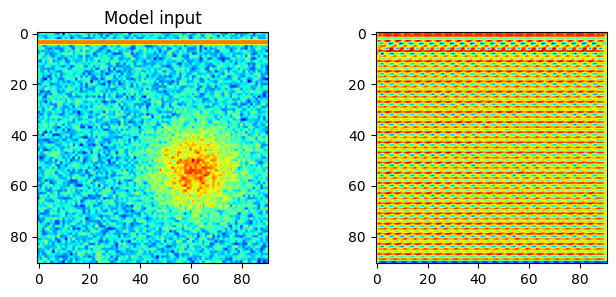

In [6]:
net,lossfun,optimizer = createNet()

X = images[:10,:,:,:]
yHat = net(X)

print(yHat.shape)
fig,ax = plt.subplots(1,2,figsize=(8,3))
ax[0].imshow(torch.squeeze(images[0,0,:,:]).detach(), cmap='jet')
ax[0].set_title('Model input')
ax[1].imshow(torch.squeeze(yHat[0,0,:,:]).detach(),cmap='jet')

In [7]:
summary(net,(1,imgSize,imgSize))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
              ReLU-2            [-1, 6, 91, 91]               0
         MaxPool2d-3            [-1, 6, 45, 45]               0
            Conv2d-4            [-1, 4, 45, 45]             220
              ReLU-5            [-1, 4, 45, 45]               0
         MaxPool2d-6            [-1, 4, 22, 22]               0
   ConvTranspose2d-7            [-1, 6, 45, 45]             222
              ReLU-8            [-1, 6, 45, 45]               0
   ConvTranspose2d-9            [-1, 1, 91, 91]              55
Total params: 557
Trainable params: 557
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 1.24
Params size (MB): 0.00
Estimated Total Size (MB): 1.27
---------------------------------------------------

In [8]:
num_epochs = 500

def trainModel():

  net,lossfun,optimizer = createNet()

  losses = []

  for epochi in range(num_epochs):

    pics2use = np.random.choice(nGauss,size=32,replace=False)
    X = images[pics2use,:,:,:]

    yHat = net(X)
    loss = lossfun(yHat,X)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())


  return net,losses


In [9]:
net,losses = trainModel()

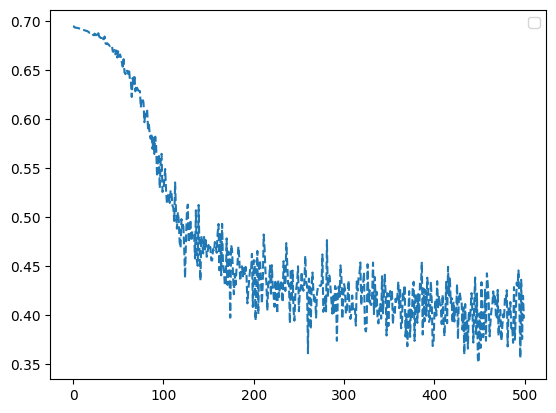

In [10]:
plt.plot(losses,'--')


plt.legend()

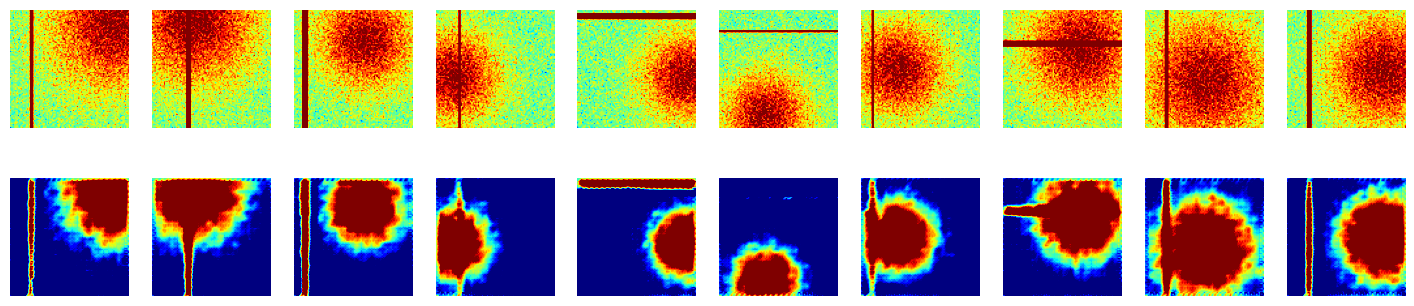

In [11]:
pics2use = np.random.choice(nGauss,size=32,replace=False)

X = images[pics2use,:,:,:]
yHat = net(X)

fig,ax = plt.subplots(2,10,figsize=(18,4))

for i in range(10):
   G = torch.squeeze(X[i,0,:,:]).detach()
   O = torch.squeeze(yHat[i,0,:,:]).detach()

   ax[0,i].imshow(G,vmin=-1,vmax=1,cmap='jet')
   ax[0,i].axis('off')

   ax[1,i].imshow(O,vmin=-1,vmax=1,cmap='jet')
   ax[1,i].axis('off')


In [12]:
print(net)

layer1W = net.enc[0].weight
layer3W = net.enc[3].weight
layer4W = net.dec[0].weight
layer6W = net.dec[2].weight

print(' ')
print(layer1W.shape)
print(layer3W.shape)
print(layer4W.shape)
print(layer6W.shape)

gausnet(
  (enc): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dec): Sequential(
    (0): ConvTranspose2d(4, 6, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(6, 1, kernel_size=(3, 3), stride=(2, 2))
  )
)
 
torch.Size([6, 1, 3, 3])
torch.Size([4, 6, 3, 3])
torch.Size([4, 6, 3, 3])
torch.Size([6, 1, 3, 3])


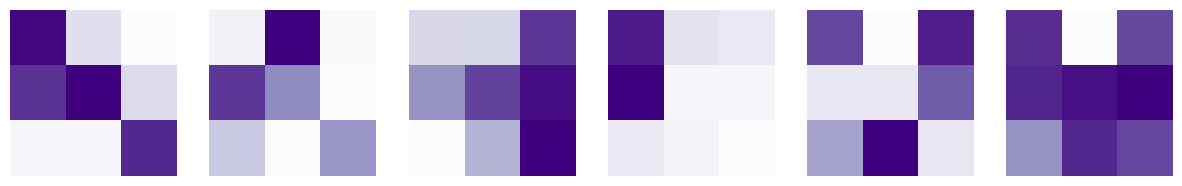

In [13]:
fig,axs = plt.subplots(1,6,figsize=(15,3))

for i,ax in enumerate(axs.flatten()):
  ax.imshow( torch.squeeze(layer1W[i,:,:,:]).detach(), cmap='Purples')
  ax.axis('off')


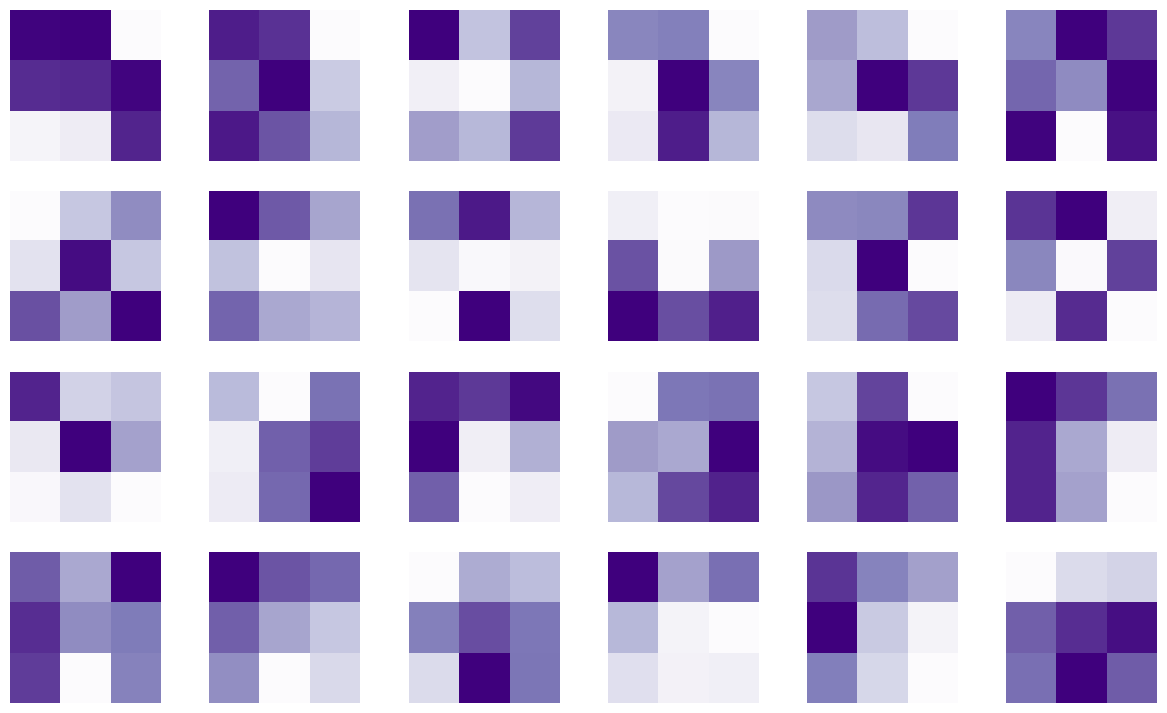

In [14]:
fig,axs = plt.subplots(4,6,figsize=(15,9))

for i in range(6*4):
  idx = np.unravel_index(i,(4,6))
  axs[idx].imshow( torch.squeeze(layer3W[idx[0], idx[1],:,:]).detach(), cmap='Purples')
  axs[idx].axis('off')